#### Imports 

In [47]:
#general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#qiskit imports
from qiskit import Aer, execute
from qiskit.aqua import QuantumInstance
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name

#scikit-learn imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import sklearn.svm as svm
from sklearn.metrics import accuracy_score
from qiskit_machine_learning.kernels import QuantumKernel

### Load data

In [38]:
df = pd.read_csv('ai4i2020.csv')

df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [3]:
#Only part of the dataset will be used
df = df.sample(200)

df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
46,47,M14906,M,298.7,309.0,1843,25.8,130,0,0,0,0,0,0
9750,9751,L56930,L,298.7,310.0,1555,32.6,197,0,0,0,0,0,0
4124,4125,L51304,L,302.1,310.6,1385,53.6,5,0,0,0,0,0,0
8298,8299,H37712,H,298.7,310.1,1435,45.6,37,0,0,0,0,0,0
9365,9366,M24225,M,298.0,308.6,1254,55.8,65,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6827,6828,M21687,M,301.0,310.9,1515,41.8,170,0,0,0,0,0,0
8519,8520,L55699,L,298.3,309.6,1420,44.1,197,0,0,0,0,0,0
6789,6790,M21649,M,301.1,310.5,1646,30.7,76,0,0,0,0,0,0
9516,9517,L56696,L,298.9,310.1,1341,54.5,51,0,0,0,0,0,0


In [48]:
#PCA 


### Feature Preparation

In [39]:
dic = {'L' : -1, 'M' : 0, 'H'  : 1}

df['TypeNum'] = df['Type'].apply(lambda x : dic[x])

In [40]:
features_labels = ['TypeNum', 'Air temperature [K]',
    'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
    'Tool wear [min]']
    
target_label = ['Machine failure']

df = df[features_labels + target_label]

### train-test split and standardize

In [41]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    df[features_labels], df[target_label], test_size=0.2, random_state=42)

#8000 for training, 2000 for testing

In [42]:
# Standardize
ss = StandardScaler()
Xtrain = ss.fit_transform(Xtrain)
Xtest = ss.transform(Xtest)

# Quantum SVM approach

In [39]:
shots = 10e03

feature_dimension = len(features_labels)
backend = Aer.get_backend('statevector_simulator')
feature_map = ZZFeatureMap(feature_dimension, reps = 2)

In [40]:
QKernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)

example: parametric circuit for first two samples

/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


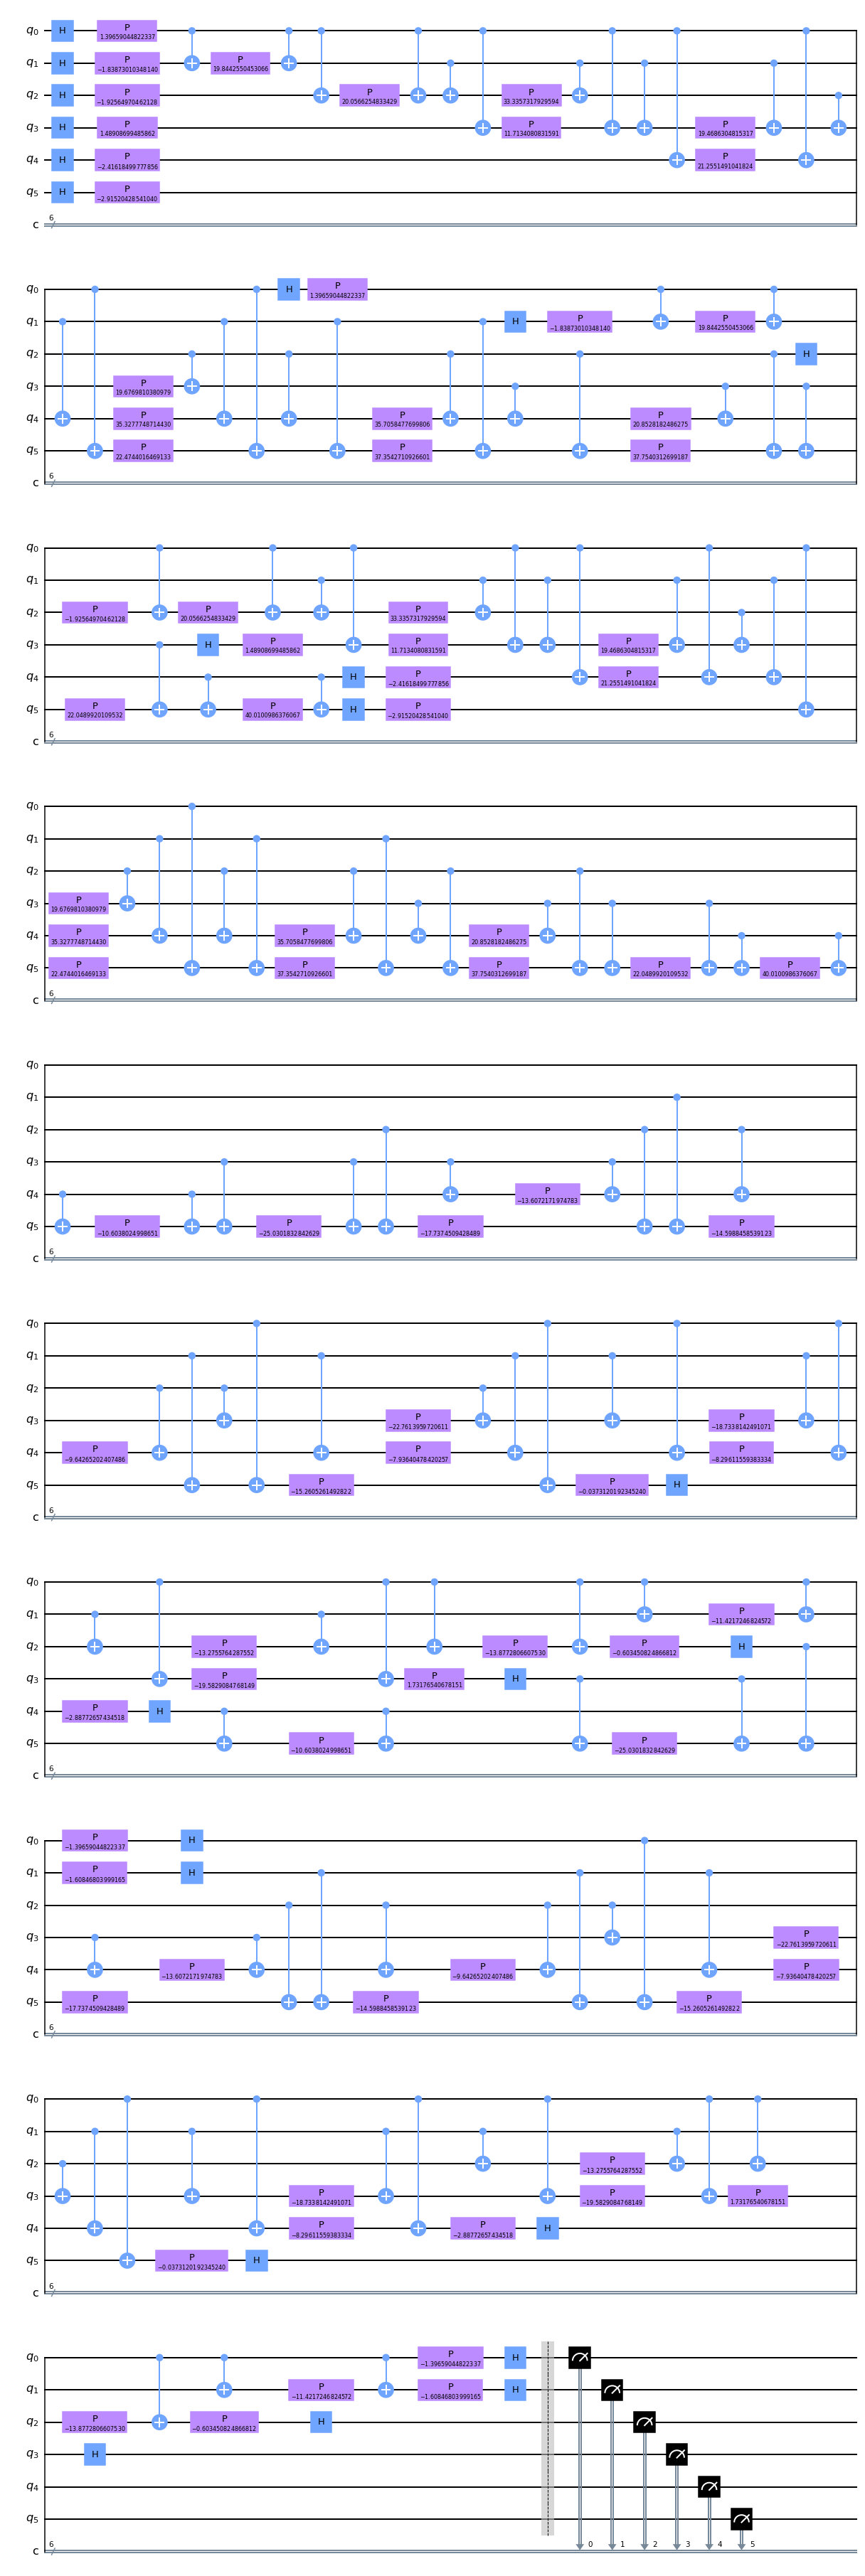

In [41]:
QKernel.construct_circuit(Xtrain[0], Xtrain[1]).decompose().decompose().draw(output= 'mpl')

let's run the QSVM

In [42]:
matrix_train = QKernel.evaluate(x_vec=Xtrain)
matrix_test = QKernel.evaluate(x_vec=Xtest, y_vec=Xtrain)

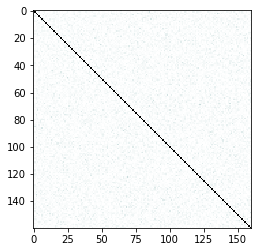

In [43]:
img = plt.imshow(np.asmatrix(matrix_train), interpolation = 'nearest', origin='upper', cmap = 'bone_r')

In [44]:
qsvc = svm.SVC(kernel='precomputed')
qsvc.fit(matrix_train, ytrain)
quantum_score = qsvc.score(matrix_test, ytest)

/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [45]:
quantum_score

0.925

In [45]:
#Linear SVM

CSVM = svm.SVC(kernel = 'linear') 
CSVM.fit(Xtrain, np.ravel(ytrain))



SVC(kernel='linear')

In [46]:
ypred = CSVM.predict(Xtest)

accuracy_score(ypred, ytest)



0.9695